In [14]:
import zipfile
import os

# Path to the zip file and the extraction directory
zip_file_path = 'Captcha.zip'
extraction_dir = 'extracted_images'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

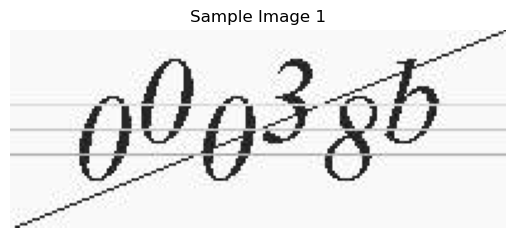

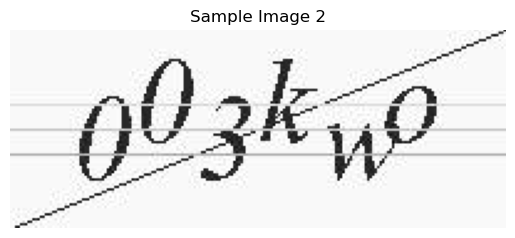

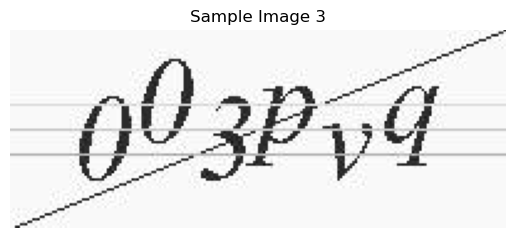

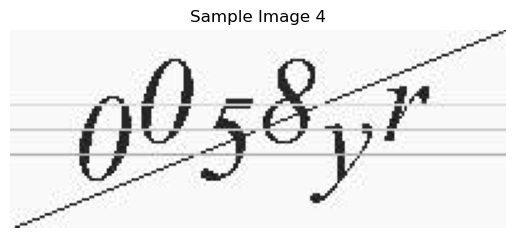

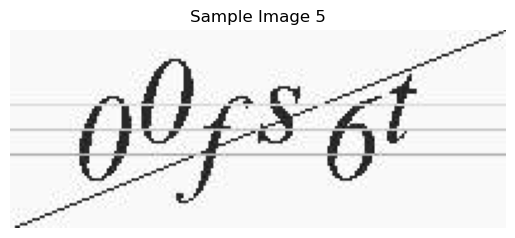

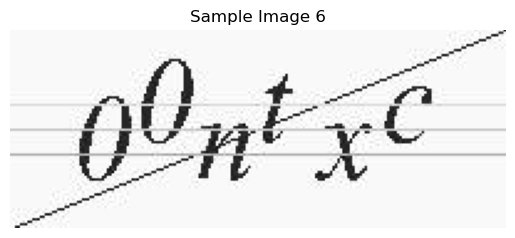

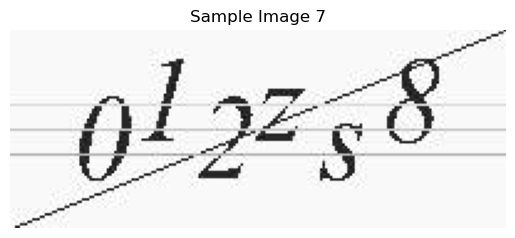

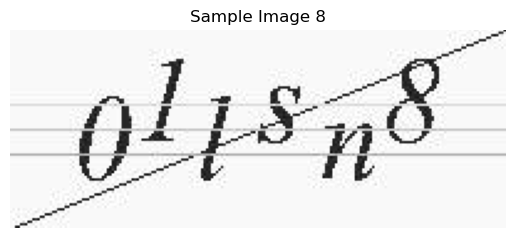

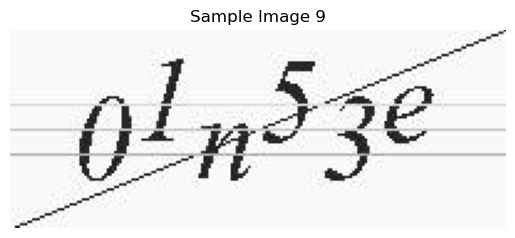

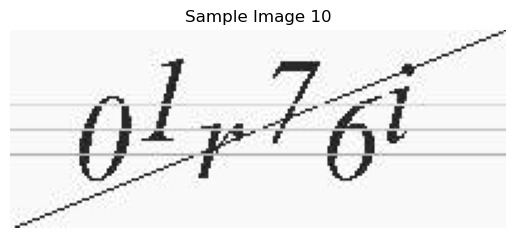

In [17]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_display_sample_images(folder, num_images=10):
    cap_folder = os.path.join(folder, 'CAP')
    images_displayed = 0
    
    for filename in os.listdir(cap_folder):
        if images_displayed >= num_images:
            break
        img_path = os.path.join(cap_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if img is not None:
            plt.imshow(img, cmap='gray')
            plt.title(f'Sample Image {images_displayed + 1}')
            plt.axis('off')
            plt.show()
            images_displayed += 1

# Assuming the extracted images are in 'extracted_images'
extraction_dir = 'extracted_images'
load_and_display_sample_images(extraction_dir, num_images=10)


Loading images from folder...
Loaded 4604 images.
Image shape: (100, 100), Label: 00038b.jpg


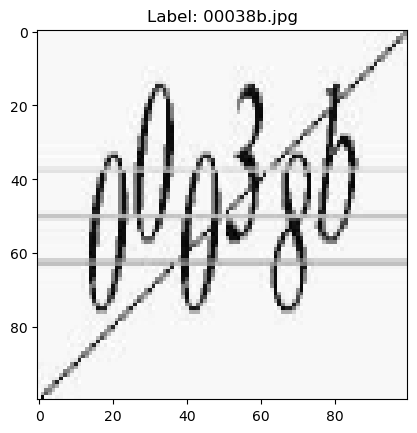

Image shape: (100, 100), Label: 003kwo.jpg


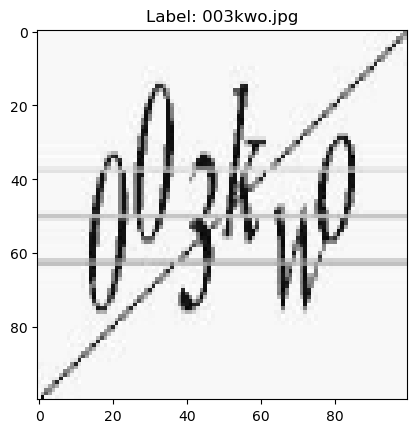

Image shape: (100, 100), Label: 003pvq.jpg


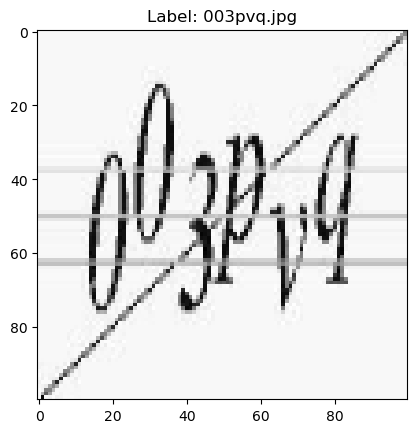

Image shape: (100, 100), Label: 00fs6t.jpg


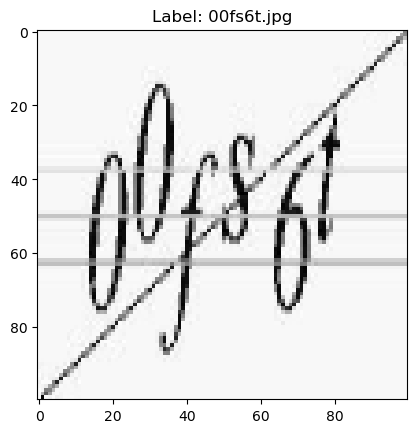

Image shape: (100, 100), Label: 00ntxc.jpg


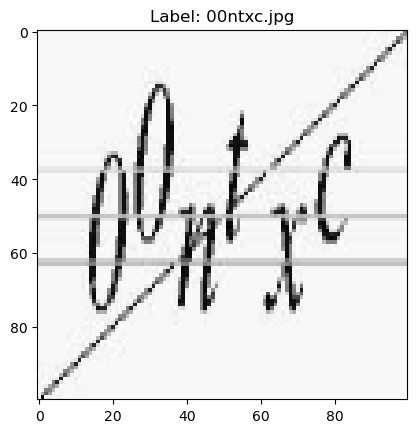

Images reshaped and normalized.
Encoding labels...
Labels encoded.


In [18]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    labels = []
    print("Loading images from folder...")
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust based on your image file extensions
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (100, 100))  # Resize images to 100x100 pixels
                images.append(img)
                label = filename.split('_')[0]  # Assuming the label is the first part of the filename
                labels.append(label)
    print(f"Loaded {len(images)} images.")
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_from_folder('extracted_images/CAP')

# Print some samples to verify
for i in range(5):
    print(f"Image shape: {images[i].shape}, Label: {labels[i]}")
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.show()

images = images.reshape(-1, 100, 100, 1).astype('float32') / 255.0  # Normalize and reshape images
print("Images reshaped and normalized.")

# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)
print("Labels encoded.")


In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (100, 100, 1)
num_classes = len(label_encoder.classes_)
model = create_cnn_model(input_shape, num_classes)
print("CNN model created.")

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled.")

X_train, X_val, y_train, y_val = train_test_split(images, categorical_labels, test_size=0.2, random_state=42)
print("Training and validation sets created.")

print("Training the model...")
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
print("Model training complete.")


CNN model created.
Model compiled.
Training and validation sets created.
Training the model...
Epoch 1/10
116/116 [==============================] - 17s 135ms/step - loss: 8.4530 - accuracy: 0.0000e+00 - val_loss: 8.4848 - val_accuracy: 0.0000e+00
Epoch 2/10
116/116 [==============================] - 15s 131ms/step - loss: 8.4172 - accuracy: 0.0000e+00 - val_loss: 8.5750 - val_accuracy: 0.0000e+00
Epoch 3/10
116/116 [==============================] - 15s 130ms/step - loss: 8.3984 - accuracy: 0.0000e+00 - val_loss: 8.6632 - val_accuracy: 0.0000e+00
Epoch 4/10
116/116 [==============================] - 15s 126ms/step - loss: 8.3819 - accuracy: 0.0000e+00 - val_loss: 8.7491 - val_accuracy: 0.0000e+00
Epoch 5/10
116/116 [==============================] - 14s 123ms/step - loss: 8.3674 - accuracy: 0.0000e+00 - val_loss: 8.8329 - val_accuracy: 0.0000e+00
Epoch 6/10
116/116 [==============================] - 14s 123ms/step - loss: 8.3545 - accuracy: 0.0000e+00 - val_loss: 8.9146 - val_accuracy

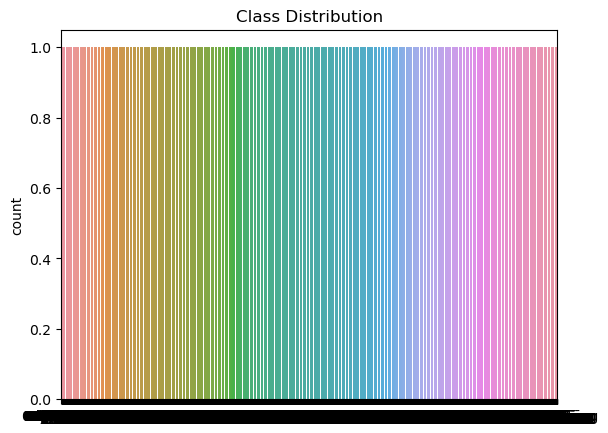

In [20]:
import seaborn as sns
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.show()


In [21]:
from keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

# Train the model with data augmentation
print("Training the model with data augmentation...")
model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=10)
print("Model training complete.")


Training the model with data augmentation...
Epoch 1/10
116/116 [==============================] - 17s 138ms/step - loss: 8.3082 - accuracy: 2.7152e-04 - val_loss: 9.2949 - val_accuracy: 0.0000e+00
Epoch 2/10
116/116 [==============================] - 15s 128ms/step - loss: 8.3016 - accuracy: 0.0000e+00 - val_loss: 9.3659 - val_accuracy: 0.0000e+00
Epoch 3/10
116/116 [==============================] - 15s 127ms/step - loss: 8.2955 - accuracy: 0.0000e+00 - val_loss: 9.4356 - val_accuracy: 0.0000e+00
Epoch 4/10
116/116 [==============================] - 15s 130ms/step - loss: 8.2901 - accuracy: 0.0000e+00 - val_loss: 9.5039 - val_accuracy: 0.0000e+00
Epoch 5/10
116/116 [==============================] - 17s 143ms/step - loss: 8.2850 - accuracy: 2.7152e-04 - val_loss: 9.5709 - val_accuracy: 0.0000e+00
Epoch 6/10
116/116 [==============================] - 16s 137ms/step - loss: 8.2805 - accuracy: 2.7152e-04 - val_loss: 9.6367 - val_accuracy: 0.0000e+00
Epoch 7/10
116/116 [=================

# RCNN

In [22]:
pip install tensorflow opencv-python pandas numpy matplotlib


In [28]:
 #Path to your CAPTCHA images
image_folder = 'extracted_images/CAP'

# Get the list of image files
image_files = os.listdir(image_folder)

# Extract labels from filenames
labels = [os.path.splitext(filename)[0] for filename in image_files]

# Print unique characters found in filenames
unique_characters = set(''.join(labels))
print(f"Unique characters in filenames: {unique_characters}")

Unique characters in filenames: {'1', 'i', 'o', 'g', '4', '.', 'u', 's', ',', 'w', 'z', 'q', '6', 'b', '8', '9', 'f', '5', 'v', 'p', 'l', 'e', 'y', 'x', 'n', '7', '2', 'c', '3', 't', 'a', 'd', 'h', 'r', '0', 'k', 'm', 'j', '_', 'C'}


In [31]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Define the path to your CAPTCHA images
image_folder = 'extracted_images/CAP'
print("Step 1: Defined the path to CAPTCHA images")

# Step 2: Get the list of image files
image_files = os.listdir(image_folder)
print(f"Step 2: Found {len(image_files)} image files")

# Step 3: Extract labels from filenames
labels = [os.path.splitext(filename)[0] for filename in image_files]
print("Step 3: Extracted labels from filenames")

# Step 4: Print unique characters found in filenames
unique_characters = set(''.join(labels))
print(f"Step 4: Unique characters in filenames: {unique_characters}")

# Step 5: Encode labels
all_characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz,._'
label_encoder = LabelEncoder()
label_encoder.fit(np.array(list(all_characters)))
print("Step 5: Encoded labels")

# Step 6: Pad or truncate labels to a fixed length
max_label_length = max(len(label) for label in labels)
padded_labels = [label.ljust(max_label_length, '_')[:max_label_length] for label in labels]
print("Step 6: Padded or truncated labels to a fixed length")

# Step 7: Encode labels, handling only valid characters
encoded_labels = [label_encoder.transform(list(label)) for label in padded_labels]
print("Step 7: Encoded labels, handling only valid characters")

# Step 8: Remove any labels that could not be encoded
valid_indices = [i for i, label in enumerate(encoded_labels) if label is not None]
encoded_labels = [encoded_labels[i] for i in valid_indices]
image_files = [image_files[i] for i in valid_indices]
print("Step 8: Removed labels that could not be encoded")

# Step 9: One-hot encode labels
def one_hot_encode(labels, num_classes):
    return np.array([tf.keras.utils.to_categorical(label, num_classes=num_classes) for label in labels])

encoded_labels = one_hot_encode(encoded_labels, num_classes=len(all_characters))
print("Step 9: One-hot encoded labels")


Step 1: Defined the path to CAPTCHA images
Step 2: Found 5002 image files
Step 3: Extracted labels from filenames
Step 4: Unique characters in filenames: {'1', 'i', 'o', 'g', '4', '.', 'u', 's', ',', 'w', 'z', 'q', '6', 'b', '8', '9', 'f', '5', 'v', 'p', 'l', 'e', 'y', 'x', 'n', '7', '2', 'c', '3', 't', 'a', 'd', 'h', 'r', '0', 'k', 'm', 'j', '_', 'C'}
Step 5: Encoded labels
Step 6: Padded or truncated labels to a fixed length
Step 7: Encoded labels, handling only valid characters
Step 8: Removed labels that could not be encoded
Step 9: One-hot encoded labels


In [32]:
# Step 10: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_files, encoded_labels, test_size=0.2, random_state=42)
print(f"Step 10: Split data into {len(X_train)} training and {len(X_val)} validation samples")

# Step 11: Data generator
def data_generator(filenames, labels, batch_size):
    while True:
        for start in range(0, len(filenames), batch_size):
            end = min(start + batch_size, len(filenames))
            batch_filenames = filenames[start:end]
            batch_labels = labels[start:end]
            images = [tf.image.decode_image(tf.io.read_file(os.path.join(image_folder, filename)), channels=1) for filename in batch_filenames]
            images = [tf.image.resize(image, [40, 100]) for image in images]
            images = tf.stack(images)
            yield images, batch_labels
print("Step 11: Defined data generator")

Step 10: Split data into 4001 training and 1001 validation samples
Step 11: Defined data generator


In [39]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import UnidentifiedImageError

# Step 1: Define the path to CAPTCHA images
print("Step 1: Defining the path to CAPTCHA images...")
image_folder = 'extracted_images/CAP'

# Step 2: Get the list of image files
print("Step 2: Getting the list of image files...")
image_files = os.listdir(image_folder)

# Step 3: Extract labels from filenames
print("Step 3: Extracting labels from filenames...")
labels = [os.path.splitext(filename)[0] for filename in image_files]

# Step 4: Print unique characters found in filenames
print("Step 4: Printing unique characters found in filenames...")
unique_characters = set(''.join(labels))
print(f"Unique characters in filenames: {unique_characters}")

# Step 5: Define all possible characters
print("Step 5: Defining all possible characters...")
all_characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz,._'

# Step 6: Create a label encoder and fit it
print("Step 6: Creating and fitting a label encoder...")
label_encoder = LabelEncoder()
label_encoder.fit(np.array(list(all_characters)))

# Step 7: Encode labels, handling only valid characters
print("Step 7: Encoding labels, handling only valid characters...")
def encode_label(label, encoder):
    try:
        return encoder.transform(list(label))
    except ValueError as e:
        print(f"Error encoding label {label}: {e}")
        return None

encoded_labels = [encode_label(label, label_encoder) for label in labels]

# Step 8: Remove any labels that could not be encoded
print("Step 8: Removing any labels that could not be encoded...")
valid_indices = [i for i, label in enumerate(encoded_labels) if label is not None]
encoded_labels = [encoded_labels[i] for i in valid_indices]
image_files = [image_files[i] for i in valid_indices]

# Step 9: Pad the encoded labels to a fixed length
print("Step 9: Padding the encoded labels to a fixed length...")
max_label_length = max(len(label) for label in encoded_labels)
encoded_labels = pad_sequences(encoded_labels, maxlen=max_label_length, padding='post')
print(f"Padded encoded labels shape: {encoded_labels.shape}")

# Step 10: One-hot encode the labels
print("Step 10: One-hot encoding the labels...")
num_classes = len(all_characters)
encoded_labels = np.array([to_categorical(label, num_classes=num_classes) for label in encoded_labels])
print(f"Shape of encoded labels: {encoded_labels.shape}")

# Step 11: Load images and preprocess them
print("Step 11: Loading and preprocessing images...")
def load_images(image_files, image_folder):
    images = []
    valid_files = []
    for file in image_files:
        img_path = os.path.join(image_folder, file)
        try:
            img = load_img(img_path, color_mode='grayscale')
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            valid_files.append(file)
        except UnidentifiedImageError:
            print(f"Warning: Could not identify image file {file}. Skipping.")
    return np.array(images), valid_files

images, valid_image_files = load_images(image_files, image_folder)
print(f"Shape of images: {images.shape}")

# Update encoded labels and image files based on valid images
encoded_labels = np.array([encoded_labels[image_files.index(file)] for file in valid_image_files])

# Step 12: Split data into training and validation sets
print("Step 12: Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

# Step 13: Define a data generator
print("Step 13: Defining a data generator...")
def data_generator(X, y, batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], y[i:i+batch_size]

# Step 14: Build the model
print("Step 14: Building the model...")
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(images.shape[1], images.shape[2], images.shape[3])),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(max_label_length * num_classes, activation='softmax'),
    Reshape((max_label_length, num_classes))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 15: Train the model
print("Step 15: Training the model...")
history = model.fit(
    data_generator(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=data_generator(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32,
    epochs=50
)

# Step 16: Print shapes of predicted labels and ground truth labels
print("Step 16: Printing shapes of predicted labels and ground truth labels...")
predicted_labels = model.predict(data_generator(X_val, y_val, batch_size=32), steps=len(X_val) // 32)
print(f"Shape of predicted labels: {predicted_labels.shape}")
print(f"Shape of ground truth labels: {y_val.shape}")

print("Model training completed successfully!")


Step 1: Defining the path to CAPTCHA images...
Step 2: Getting the list of image files...
Step 3: Extracting labels from filenames...
Step 4: Printing unique characters found in filenames...
Unique characters in filenames: {'1', 'i', 'o', 'g', '4', '.', 'u', 's', ',', 'w', 'z', 'q', '6', 'b', '8', '9', 'f', '5', 'v', 'p', 'l', 'e', 'y', 'x', 'n', '7', '2', 'c', '3', 't', 'a', 'd', 'h', 'r', '0', 'k', 'm', 'j', '_', 'C'}
Step 5: Defining all possible characters...
Step 6: Creating and fitting a label encoder...
Step 7: Encoding labels, handling only valid characters...
Step 8: Removing any labels that could not be encoded...
Step 9: Padding the encoded labels to a fixed length...
Padded encoded labels shape: (5002, 25)
Step 10: One-hot encoding the labels...
Shape of encoded labels: (5002, 25, 65)
Step 11: Loading and preprocessing images...
Shape of images: (5001, 80, 200, 1)
Step 12: Splitting data into training and validation sets...
Shape of X_train: (4000, 80, 200, 1)
Shape of X_va

In [40]:
# Save the model
model.save('captcha_recognition_model.h5')

print("Model saved successfully!")

C:\Users\sanya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


In [51]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Load the trained model
print("Loading the trained model...")
model = load_model("captcha_recognition_model.h5")
print("Model loaded successfully!")

# Step 2: Load the label encoder
print("Loading label encoder...")
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)
print("Label encoder loaded successfully!")

# Step 3: Preprocess the CAPTCHA image
def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        return img_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

captcha_image_path = 'path/to/your/CAPTCHA/image.jpg'  # Provide the path to your CAPTCHA image
captcha_image_array = preprocess_image(captcha_image_path)
if captcha_image_array is None:
    print("Error loading CAPTCHA image. Please check the file path.")
else:
    captcha_image_array = captcha_image_array.reshape(1, captcha_image_array.shape[0], captcha_image_array.shape[1], 1)

# Step 4: Use the model to predict the characters in the CAPTCHA
print("Predicting CAPTCHA characters...")
predicted_labels = model.predict(captcha_image_array)

# Step 5: Decode the predicted labels using the label encoder
def decode_labels(predicted_labels, label_encoder):
    decoded_labels = []
    for label in predicted_labels[0]:
        decoded_label = label_encoder.inverse_transform([np.argmax(label)])
        decoded_labels.append(decoded_label[0] if decoded_label[0] != '-' else '')
    return decoded_labels

decoded_captcha = decode_labels(predicted_labels, label_encoder)
print("Predicted CAPTCHA:", ''.join(decoded_captcha))


Loading the trained model...
Model loaded successfully!
Loading label encoder...


FileNotFoundError: [Errno 2] No such file or directory: 'classes.npy'

In [52]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import UnidentifiedImageError

# Step 1: Define the path to CAPTCHA images
print("Step 1: Defining the path to CAPTCHA images...")
image_folder = 'extracted_images/CAP'

# Step 2: Get the list of image files
print("Step 2: Getting the list of image files...")
image_files = os.listdir(image_folder)

# Step 3: Extract labels from filenames
print("Step 3: Extracting labels from filenames...")
labels = [os.path.splitext(filename)[0] for filename in image_files]

# Step 4: Print unique characters found in filenames
print("Step 4: Printing unique characters found in filenames...")
unique_characters = set(''.join(labels))
print(f"Unique characters in filenames: {unique_characters}")

# Step 5: Define all possible characters
print("Step 5: Defining all possible characters...")
all_characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz,._'

# Step 6: Create a label encoder and fit it
print("Step 6: Creating and fitting a label encoder...")
label_encoder = LabelEncoder()
label_encoder.fit(np.array(list(all_characters)))

# Save the label encoder classes to a file
np.save('classes.npy', label_encoder.classes_)

# Step 7: Encode labels, handling only valid characters
print("Step 7: Encoding labels, handling only valid characters...")
# Rest of the code remains the same
def encode_label(label, encoder):
    try:
        return encoder.transform(list(label))
    except ValueError as e:
        print(f"Error encoding label {label}: {e}")
        return None

encoded_labels = [encode_label(label, label_encoder) for label in labels]

# Step 8: Remove any labels that could not be encoded
print("Step 8: Removing any labels that could not be encoded...")
valid_indices = [i for i, label in enumerate(encoded_labels) if label is not None]
encoded_labels = [encoded_labels[i] for i in valid_indices]
image_files = [image_files[i] for i in valid_indices]

# Step 9: Pad the encoded labels to a fixed length
print("Step 9: Padding the encoded labels to a fixed length...")
max_label_length = max(len(label) for label in encoded_labels)
encoded_labels = pad_sequences(encoded_labels, maxlen=max_label_length, padding='post')
print(f"Padded encoded labels shape: {encoded_labels.shape}")

# Step 10: One-hot encode the labels
print("Step 10: One-hot encoding the labels...")
num_classes = len(all_characters)
encoded_labels = np.array([to_categorical(label, num_classes=num_classes) for label in encoded_labels])
print(f"Shape of encoded labels: {encoded_labels.shape}")

# Step 11: Load images and preprocess them
print("Step 11: Loading and preprocessing images...")
def load_images(image_files, image_folder):
    images = []
    valid_files = []
    for file in image_files:
        img_path = os.path.join(image_folder, file)
        try:
            img = load_img(img_path, color_mode='grayscale')
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            valid_files.append(file)
        except UnidentifiedImageError:
            print(f"Warning: Could not identify image file {file}. Skipping.")
    return np.array(images), valid_files

images, valid_image_files = load_images(image_files, image_folder)
print(f"Shape of images: {images.shape}")

# Update encoded labels and image files based on valid images
encoded_labels = np.array([encoded_labels[image_files.index(file)] for file in valid_image_files])

# Step 12: Split data into training and validation sets
print("Step 12: Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

# Step 13: Define a data generator
print("Step 13: Defining a data generator...")
def data_generator(X, y, batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], y[i:i+batch_size]

# Step 14: Build the model
print("Step 14: Building the model...")
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(images.shape[1], images.shape[2], images.shape[3])),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(max_label_length * num_classes, activation='softmax'),
    Reshape((max_label_length, num_classes))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 15: Train the model
print("Step 15: Training the model...")
history = model.fit(
    data_generator(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=data_generator(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32,
    epochs=50
)

# Step 16: Print shapes of predicted labels and ground truth labels
print("Step 16: Printing shapes of predicted labels and ground truth labels...")
predicted_labels = model.predict(data_generator(X_val, y_val, batch_size=32), steps=len(X_val) // 32)
print(f"Shape of predicted labels: {predicted_labels.shape}")
print(f"Shape of ground truth labels: {y_val.shape}")

print("Model training completed successfully!")

# Save the model
model.save('captcha=recognition_model.h5')

print("Model saved successfully!")


Step 1: Defining the path to CAPTCHA images...
Step 2: Getting the list of image files...
Step 3: Extracting labels from filenames...
Step 4: Printing unique characters found in filenames...
Unique characters in filenames: {'1', 'i', 'o', 'g', '4', '.', 'u', 's', ',', 'w', 'z', 'q', '6', 'b', '8', '9', 'f', '5', 'v', 'p', 'l', 'e', 'y', 'x', 'n', '7', '2', 'c', '3', 't', 'a', 'd', 'h', 'r', '0', 'k', 'm', 'j', '_', 'C'}
Step 5: Defining all possible characters...
Step 6: Creating and fitting a label encoder...
Step 7: Encoding labels, handling only valid characters...
Step 8: Removing any labels that could not be encoded...
Step 9: Padding the encoded labels to a fixed length...
Padded encoded labels shape: (5002, 25)
Step 10: One-hot encoding the labels...
Shape of encoded labels: (5002, 25, 65)
Step 11: Loading and preprocessing images...
Shape of images: (5001, 80, 200, 1)
Step 12: Splitting data into training and validation sets...
Shape of X_train: (4000, 80, 200, 1)
Shape of X_va

C:\Users\sanya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

# Define the path to the test image
test_image_file = '00ntxc.jpg'

# Load the trained model
print("Loading the trained model...")
model = load_model('captcha_recognition_model.h5')

# Load the label encoder classes
print("Loading label encoder classes...")
label_encoder_classes = np.load('classes.npy')
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes

# Define a function to preprocess a single image
def preprocess_image(image_file):
    try:
        img = load_img(image_file, color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        return img_array
    except Exception as e:
        print(f"Warning: Could not identify image file {image_file}. Error: {e}")
        return None

# Load and preprocess the test image
print("Loading and preprocessing test image...")
test_image = preprocess_image(test_image_file)
if test_image is None:
    raise ValueError("Test image could not be loaded or identified.")

print(f"Shape of test image: {test_image.shape}")

# Predict the label for the test image
print("Predicting label for test image...")
predicted_label = model.predict(test_image)
print(f"Shape of predicted label: {predicted_label.shape}")

# Decode the predicted label to readable text
def decode_prediction(prediction, label_encoder):
    decoded_label = ''.join(label_encoder.inverse_transform(np.argmax(prediction, axis=-1)))
    # Remove any padding or empty characters
    decoded_label = decoded_label.replace(',', '')
    return decoded_label

decoded_label = decode_prediction(predicted_label[0], label_encoder)

# Print the prediction
print("Predicted label for test image:")
print(f"{test_image_file}: {decoded_label}")

print("Model testing completed successfully!")


Loading the trained model...
Loading label encoder classes...
Loading and preprocessing test image...
Shape of test image: (1, 80, 200, 1)
Predicting label for test image...
1/1 [==============================] - 0s 217ms/step
Shape of predicted label: (1, 25, 65)
Predicted label for test image:
00ntxc.jpg: 00ntxc
Model testing completed successfully!


In [ ]:
00fs6t.jpg

00ntxc.jpg

0a27s7.jpg

0aewi3.jpg

0afvbz.jpg

0akkri.jpg

0ao47k.jpg

0apb5n.jpg

0biv8f.jpg

0dvpga.jpg

0e1876.jpg

0e23r7.jpg

0e3zlu.jpg

0e6nor.jpg

0e7ufb.jpeg

0eifek.jpg

0eqz58.jpg

0fhpf1.jpg

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

# Define the list of test image files
test_image_files = [
    '00ntxc.jpg', '00fs6t.jpg', '0a27s7.jpg', '0aewi3.jpg', '0afvbz.jpg',
    '0akkri.jpg', '0ao47k.jpg', '0apb5n.jpg', '0biv8f.jpg', '0dvpga.jpg',
    '0e1876.jpg', '0e23r7.jpg', '0e3zlu.jpg', '0e6nor.jpg', '0e7ufb.jpeg',
    '0eifek.jpg', '0eqz58.jpg', '0fhpf1.jpg'
]

# Load the trained model
print("Loading the trained model...")
model = load_model('captcha_recognition_model.h5')

# Load the label encoder classes
print("Loading label encoder classes...")
label_encoder_classes = np.load('classes.npy')
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes

# Define a function to preprocess a single image
def preprocess_image(image_file):
    try:
        img = load_img(image_file, color_mode='grayscale', target_size=(80, 200))  # Update target_size
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        return img_array
    except Exception as e:
        print(f"Warning: Could not identify image file {image_file}. Error: {e}")
        return None

# Define a function to decode the prediction to readable text
def decode_prediction(prediction, label_encoder):
    decoded_label = ''.join(label_encoder.inverse_transform(np.argmax(prediction, axis=-1)))
    return decoded_label.replace(',', '')

# Loop through each test image file
for test_image_file in test_image_files:
    print(f"Processing {test_image_file}...")
    
    # Load and preprocess the test image
    test_image = preprocess_image(test_image_file)
    if test_image is None:
        print(f"Skipping {test_image_file} due to loading error.")
        continue
    
    # Predict the label for the test image
    predicted_label = model.predict(test_image)
    
    # Decode the predicted label to readable text
    decoded_label = decode_prediction(predicted_label[0], label_encoder)
    
    # Print the prediction
    print(f"Predicted label for {test_image_file}: {decoded_label}")

print("Model testing completed successfully!")


Loading the trained model...
Loading label encoder classes...
Processing 00ntxc.jpg...
1/1 [==============================] - 0s 320ms/step
Predicted label for 00ntxc.jpg: 00ntxc
Processing 00fs6t.jpg...
1/1 [==============================] - 0s 35ms/step
Predicted label for 00fs6t.jpg: 00fs6t
Processing 0a27s7.jpg...
1/1 [==============================] - 0s 31ms/step
Predicted label for 0a27s7.jpg: 0a27s7
Processing 0aewi3.jpg...
1/1 [==============================] - 0s 35ms/step
Predicted label for 0aewi3.jpg: 0aewi3
Processing 0afvbz.jpg...
1/1 [==============================] - 0s 31ms/step
Predicted label for 0afvbz.jpg: 0afvbz
Processing 0akkri.jpg...
1/1 [==============================] - 0s 41ms/step
Predicted label for 0akkri.jpg: 0akkrb
Processing 0ao47k.jpg...
1/1 [==============================] - 0s 24ms/step
Predicted label for 0ao47k.jpg: 0ao47k
Processing 0apb5n.jpg...
1/1 [==============================] - 0s 35ms/step
Predicted label for 0apb5n.jpg: 0apb5n
Processin

In [3]:
import zipfile
import os

# Path to the zip file and the extraction directory
zip_file_path = 'captcha.zip'
extraction_dir = 'extracted_images1'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# 10000 captcha with 50 epochs

In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import UnidentifiedImageError

# Step 1: Define the paths to CAPTCHA images
print("Step 1: Defining the paths to CAPTCHA images...")
image_folders = ['extracted_images/CAP', 'extracted_images1']

# Step 2: Get the list of image files from both directories
print("Step 2: Getting the list of image files from both directories...")
image_files = []
for folder in image_folders:
    image_files += [os.path.join(folder, file) for file in os.listdir(folder) if os.path.isfile(os.path.join(folder, file))]

# Step 3: Extract labels from filenames
print("Step 3: Extracting labels from filenames...")
labels = [os.path.splitext(os.path.basename(filename))[0] for filename in image_files]

# Step 4: Print unique characters found in filenames
print("Step 4: Printing unique characters found in filenames...")
unique_characters = set(''.join(labels))
print(f"Unique characters in filenames: {unique_characters}")

# Step 5: Define all possible characters
print("Step 5: Defining all possible characters...")
all_characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz,._'

# Step 6: Create a label encoder and fit it
print("Step 6: Creating and fitting a label encoder...")
label_encoder = LabelEncoder()
label_encoder.fit(np.array(list(all_characters)))

# Save the label encoder classes to a file
np.save('classes.npy', label_encoder.classes_)

# Step 7: Encode labels, handling only valid characters
print("Step 7: Encoding labels, handling only valid characters...")
def encode_label(label, encoder):
    try:
        return encoder.transform(list(label))
    except ValueError as e:
        print(f"Error encoding label {label}: {e}")
        return None

encoded_labels = [encode_label(label, label_encoder) for label in labels]

# Step 8: Remove any labels that could not be encoded
print("Step 8: Removing any labels that could not be encoded...")
valid_indices = [i for i, label in enumerate(encoded_labels) if label is not None]
encoded_labels = [encoded_labels[i] for i in valid_indices]
image_files = [image_files[i] for i in valid_indices]

# Step 9: Pad the encoded labels to a fixed length
print("Step 9: Padding the encoded labels to a fixed length...")
max_label_length = max(len(label) for label in encoded_labels)
encoded_labels = pad_sequences(encoded_labels, maxlen=max_label_length, padding='post')
print(f"Padded encoded labels shape: {encoded_labels.shape}")

# Step 10: One-hot encode the labels
print("Step 10: One-hot encoding the labels...")
num_classes = len(all_characters)
encoded_labels = np.array([to_categorical(label, num_classes=num_classes) for label in encoded_labels])
print(f"Shape of encoded labels: {encoded_labels.shape}")

# Step 11: Load images and preprocess them
print("Step 11: Loading and preprocessing images...")
def load_images(image_files):
    images = []
    valid_files = []
    for file in image_files:
        try:
            img = load_img(file, color_mode='grayscale', target_size=(80, 200))
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            valid_files.append(file)
        except UnidentifiedImageError:
            print(f"Warning: Could not identify image file {file}. Skipping.")
    return np.array(images), valid_files

images, valid_image_files = load_images(image_files)
print(f"Shape of images: {images.shape}")

# Update encoded labels and image files based on valid images
encoded_labels = np.array([encoded_labels[image_files.index(file)] for file in valid_image_files])

# Step 12: Split data into training and validation sets
print("Step 12: Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

# Step 13: Define a data generator
print("Step 13: Defining a data generator...")
def data_generator(X, y, batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], y[i:i+batch_size]

# Step 14: Build the model
print("Step 14: Building the model...")
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(images.shape[1], images.shape[2], images.shape[3])),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(max_label_length * num_classes, activation='softmax'),
    Reshape((max_label_length, num_classes))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 15: Train the model
print("Step 15: Training the model...")
history = model.fit(
    data_generator(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=data_generator(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32,
    epochs=50
)

# Step 16: Print shapes of predicted labels and ground truth labels
print("Step 16: Printing shapes of predicted labels and ground truth labels...")
predicted_labels = model.predict(data_generator(X_val, y_val, batch_size=32), steps=len(X_val) // 32)
print(f"Shape of predicted labels: {predicted_labels.shape}")
print(f"Shape of ground truth labels: {y_val.shape}")

print("Model training completed successfully!")

# Save the model
model.save('captcha-recognition_model.h5')
print("Model saved successfully!")


Step 1: Defining the paths to CAPTCHA images...
Step 2: Getting the list of image files from both directories...
Step 3: Extracting labels from filenames...
Step 4: Printing unique characters found in filenames...
Unique characters in filenames: {'.', '8', 'o', 'u', '9', 'p', 'w', 's', '7', 'q', 'm', '1', 'j', '_', 'h', '5', 'C', 'r', 'd', 'c', 'n', 'k', 'a', 'v', ',', 'x', 'f', '2', 'e', 'z', 'l', '4', '6', 't', 'b', '3', '0', 'g', 'i', 'y'}
Step 5: Defining all possible characters...
Step 6: Creating and fitting a label encoder...
Step 7: Encoding labels, handling only valid characters...
Step 8: Removing any labels that could not be encoded...
Step 9: Padding the encoded labels to a fixed length...
Padded encoded labels shape: (5002, 25)
Step 10: One-hot encoding the labels...
Shape of encoded labels: (5002, 25, 65)
Step 11: Loading and preprocessing images...
Shape of images: (5001, 80, 200, 1)
Step 12: Splitting data into training and validation sets...
Shape of X_train: (4000, 80

Epoch 44/50
125/125 [==============================] - 21s 167ms/step - loss: 0.4642 - accuracy: 0.8486 - val_loss: 0.2876 - val_accuracy: 0.9354
Epoch 45/50
125/125 [==============================] - 21s 166ms/step - loss: 0.4598 - accuracy: 0.8497 - val_loss: 0.2866 - val_accuracy: 0.9347
Epoch 46/50
125/125 [==============================] - 21s 169ms/step - loss: 0.4553 - accuracy: 0.8513 - val_loss: 0.2719 - val_accuracy: 0.9366
Epoch 47/50
125/125 [==============================] - 21s 165ms/step - loss: 0.4574 - accuracy: 0.8501 - val_loss: 0.2728 - val_accuracy: 0.9376
Epoch 48/50
125/125 [==============================] - 21s 165ms/step - loss: 0.4526 - accuracy: 0.8522 - val_loss: 0.2626 - val_accuracy: 0.9386
Epoch 49/50
125/125 [==============================] - 21s 164ms/step - loss: 0.4505 - accuracy: 0.8515 - val_loss: 0.2717 - val_accuracy: 0.9383
Epoch 50/50
125/125 [==============================] - 21s 164ms/step - loss: 0.4482 - accuracy: 0.8515 - val_loss: 0.2651 -

C:\Users\sanya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


# 10000 captcha with 100 epochs

In [5]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import UnidentifiedImageError

# Step 1: Define the paths to CAPTCHA images
print("Step 1: Defining the paths to CAPTCHA images...")
image_folders = ['extracted_images/CAP', 'extracted_images1']

# Step 2: Get the list of image files from both directories
print("Step 2: Getting the list of image files from both directories...")
image_files = []
for folder in image_folders:
    image_files += [os.path.join(folder, file) for file in os.listdir(folder) if os.path.isfile(os.path.join(folder, file))]

# Step 3: Extract labels from filenames
print("Step 3: Extracting labels from filenames...")
labels = [os.path.splitext(os.path.basename(filename))[0] for filename in image_files]

# Step 4: Print unique characters found in filenames
print("Step 4: Printing unique characters found in filenames...")
unique_characters = set(''.join(labels))
print(f"Unique characters in filenames: {unique_characters}")

# Step 5: Define all possible characters
print("Step 5: Defining all possible characters...")
all_characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz,._'

# Step 6: Create a label encoder and fit it
print("Step 6: Creating and fitting a label encoder...")
label_encoder = LabelEncoder()
label_encoder.fit(np.array(list(all_characters)))

# Save the label encoder classes to a file
np.save('classes.npy', label_encoder.classes_)

# Step 7: Encode labels, handling only valid characters
print("Step 7: Encoding labels, handling only valid characters...")
def encode_label(label, encoder):
    try:
        return encoder.transform(list(label))
    except ValueError as e:
        print(f"Error encoding label {label}: {e}")
        return None

encoded_labels = [encode_label(label, label_encoder) for label in labels]

# Step 8: Remove any labels that could not be encoded
print("Step 8: Removing any labels that could not be encoded...")
valid_indices = [i for i, label in enumerate(encoded_labels) if label is not None]
encoded_labels = [encoded_labels[i] for i in valid_indices]
image_files = [image_files[i] for i in valid_indices]

# Step 9: Pad the encoded labels to a fixed length
print("Step 9: Padding the encoded labels to a fixed length...")
max_label_length = max(len(label) for label in encoded_labels)
encoded_labels = pad_sequences(encoded_labels, maxlen=max_label_length, padding='post')
print(f"Padded encoded labels shape: {encoded_labels.shape}")

# Step 10: One-hot encode the labels
print("Step 10: One-hot encoding the labels...")
num_classes = len(all_characters)
encoded_labels = np.array([to_categorical(label, num_classes=num_classes) for label in encoded_labels])
print(f"Shape of encoded labels: {encoded_labels.shape}")

# Step 11: Load images and preprocess them
print("Step 11: Loading and preprocessing images...")
def load_images(image_files):
    images = []
    valid_files = []
    for file in image_files:
        try:
            img = load_img(file, color_mode='grayscale', target_size=(80, 200))
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            valid_files.append(file)
        except UnidentifiedImageError:
            print(f"Warning: Could not identify image file {file}. Skipping.")
    return np.array(images), valid_files

images, valid_image_files = load_images(image_files)
print(f"Shape of images: {images.shape}")

# Update encoded labels and image files based on valid images
encoded_labels = np.array([encoded_labels[image_files.index(file)] for file in valid_image_files])

# Step 12: Split data into training and validation sets
print("Step 12: Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

# Step 13: Define a data generator
print("Step 13: Defining a data generator...")
def data_generator(X, y, batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], y[i:i+batch_size]

# Step 14: Build the model
print("Step 14: Building the model...")
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(images.shape[1], images.shape[2], images.shape[3])),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(max_label_length * num_classes, activation='softmax'),
    Reshape((max_label_length, num_classes))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 15: Train the model
print("Step 15: Training the model...")
history = model.fit(
    data_generator(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=data_generator(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32,
    epochs=100
)

# Step 16: Print shapes of predicted labels and ground truth labels
print("Step 16: Printing shapes of predicted labels and ground truth labels...")
predicted_labels = model.predict(data_generator(X_val, y_val, batch_size=32), steps=len(X_val) // 32)
print(f"Shape of predicted labels: {predicted_labels.shape}")
print(f"Shape of ground truth labels: {y_val.shape}")

print("Model training completed successfully!")

# Save the model
model.save('captcha-recognition.h5')
print("Model saved successfully!")


Step 1: Defining the paths to CAPTCHA images...
Step 2: Getting the list of image files from both directories...
Step 3: Extracting labels from filenames...
Step 4: Printing unique characters found in filenames...
Unique characters in filenames: {'.', '8', 'o', 'u', '9', 'p', 'w', 's', '7', 'q', 'm', '1', 'j', '_', 'h', '5', 'C', 'r', 'd', 'c', 'n', 'k', 'a', 'v', ',', 'x', 'f', '2', 'e', 'z', 'l', '4', '6', 't', 'b', '3', '0', 'g', 'i', 'y'}
Step 5: Defining all possible characters...
Step 6: Creating and fitting a label encoder...
Step 7: Encoding labels, handling only valid characters...
Step 8: Removing any labels that could not be encoded...
Step 9: Padding the encoded labels to a fixed length...
Padded encoded labels shape: (5002, 25)
Step 10: One-hot encoding the labels...
Shape of encoded labels: (5002, 25, 65)
Step 11: Loading and preprocessing images...
Shape of images: (5001, 80, 200, 1)
Step 12: Splitting data into training and validation sets...
Shape of X_train: (4000, 80

Epoch 48/100
125/125 [==============================] - 20s 161ms/step - loss: 0.3599 - accuracy: 0.8775 - val_loss: 0.1760 - val_accuracy: 0.9678
Epoch 49/100
125/125 [==============================] - 20s 162ms/step - loss: 0.3605 - accuracy: 0.8779 - val_loss: 0.1685 - val_accuracy: 0.9659
Epoch 50/100
125/125 [==============================] - 20s 161ms/step - loss: 0.3565 - accuracy: 0.8776 - val_loss: 0.1634 - val_accuracy: 0.9667
Epoch 51/100
125/125 [==============================] - 20s 162ms/step - loss: 0.3537 - accuracy: 0.8792 - val_loss: 0.1756 - val_accuracy: 0.9683
Epoch 52/100
125/125 [==============================] - 20s 162ms/step - loss: 0.3561 - accuracy: 0.8779 - val_loss: 0.1662 - val_accuracy: 0.9697
Epoch 53/100
125/125 [==============================] - 20s 162ms/step - loss: 0.3534 - accuracy: 0.8786 - val_loss: 0.1577 - val_accuracy: 0.9684
Epoch 54/100
125/125 [==============================] - 20s 160ms/step - loss: 0.3499 - accuracy: 0.8798 - val_loss: 0

C:\Users\sanya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

# Define the list of test image files
test_image_files = [
    '00ntxc.jpg', '00fs6t.jpg', '0a27s7.jpg', '0aewi3.jpg', '0afvbz.jpg',
    '0akkri.jpg', '0ao47k.jpg', '0apb5n.jpg', '0biv8f.jpg', '0dvpga.jpg',
    '0e1876.jpg', '0e23r7.jpg', '0e3zlu.jpg', '0e6nor.jpg', '0e7ufb.jpeg',
    '0eifek.jpg', '0eqz58.jpg', '0fhpf1.jpg'
]

# Load the trained model
print("Loading the trained model...")
model = load_model('captcha-recognition.h5')

# Load the label encoder classes
print("Loading label encoder classes...")
label_encoder_classes = np.load('classes.npy')
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes

# Define a function to preprocess a single image
def preprocess_image(image_file):
    try:
        img = load_img(image_file, color_mode='grayscale', target_size=(80, 200))  # Update target_size
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        return img_array
    except Exception as e:
        print(f"Warning: Could not identify image file {image_file}. Error: {e}")
        return None

# Define a function to decode the prediction to readable text
def decode_prediction(prediction, label_encoder):
    decoded_label = ''.join(label_encoder.inverse_transform(np.argmax(prediction, axis=-1)))
    return decoded_label.replace(',', '')

# Loop through each test image file
for test_image_file in test_image_files:
    print(f"Processing {test_image_file}...")
    
    # Load and preprocess the test image
    test_image = preprocess_image(test_image_file)
    if test_image is None:
        print(f"Skipping {test_image_file} due to loading error.")
        continue
    
    # Predict the label for the test image
    predicted_label = model.predict(test_image)
    
    # Decode the predicted label to readable text
    decoded_label = decode_prediction(predicted_label[0], label_encoder)
    
    # Print the prediction
    print(f"Predicted label for {test_image_file}:    {decoded_label}")

print("Model testing completed successfully!")


Loading the trained model...
Loading label encoder classes...
Processing 00ntxc.jpg...
1/1 [==============================] - 0s 110ms/step
Predicted label for 00ntxc.jpg:    00ntxc
Processing 00fs6t.jpg...
1/1 [==============================] - 0s 47ms/step
Predicted label for 00fs6t.jpg:    000s6t
Processing 0a27s7.jpg...
1/1 [==============================] - 0s 36ms/step
Predicted label for 0a27s7.jpg:    0a27s7
Processing 0aewi3.jpg...
1/1 [==============================] - 0s 41ms/step
Predicted label for 0aewi3.jpg:    0aewi3
Processing 0afvbz.jpg...
1/1 [==============================] - 0s 92ms/step
Predicted label for 0afvbz.jpg:    0afvbz
Processing 0akkri.jpg...
1/1 [==============================] - 0s 38ms/step
Predicted label for 0akkri.jpg:    oakkri
Processing 0ao47k.jpg...
1/1 [==============================] - 0s 34ms/step
Predicted label for 0ao47k.jpg:    0ao47k
Processing 0apb5n.jpg...
1/1 [==============================] - 0s 33ms/step
Predicted label for 0apb5n.